# Distribución granulométrica de suelos

© 2023 Daniel F. Ruiz, Exneyder A. Montoya-Araque y Universidad EAFIT.

Este notebook se puede ejecutar interactivamente en [Google - Colab](https://colab.research.google.com/github/AppliedMechanics-EAFIT/soil_mechanics/blob/main/notebooks/particle_size_distrib.ipynb).

Las rutinas de clasificación se basan parcialmente en la norma [ASTM ASTM D6913/D6913M-17](https://www.astm.org/d6913-04r09e01.html)

## Required modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import norm, lognorm
from scipy.optimize import curve_fit, minimize
from ipywidgets import interact, widgets, fixed
from IPython import get_ipython
from IPython.display import display, clear_output

if 'google.colab' in str(get_ipython()):
    print('Running on CoLab. Installing the required modules...')
    %pip install ipympl &> ~/pip-log.txt
    from google.colab import output, files
    output.enable_custom_widget_manager()
else:
    import tkinter as tk
    from tkinter.filedialog import askopenfilename

%matplotlib widget

plt.style.use("default")
mpl.rcParams.update(
    {
        # 'figure.dpi': 300,
        'interactive': False,
        "text.usetex": False,  # Use mathtext, not LaTeX
        "font.family": "cmr10",  # Use the Computer modern font
        "mathtext.fontset": "cm",
        "axes.formatter.use_mathtext": True,
        "axes.unicode_minus": False,
    }
)

# Reading the input data

In [2]:
if 'google.colab' in str(get_ipython()):
    file = files.upload()
    df = pd.read_excel(list(file.values())[0])
else:
    tk.Tk().withdraw() # part of the import if you are not using other tkinter functions
    file = askopenfilename()
    df = pd.read_excel(file)

# Tabulated input data

In [3]:
df

,Tamiz,Abertura_(mm),Retenido_(g)
0,"2 1/2""",63.500,NaN
1,"2""",50.800,NaN
2,"1 1/2""",38.100,NaN
3,"1""",25.400,NaN
4,"3/4""",19.100,NaN
5,"1/2""",12.700,0.0
6,NaN,4.000,3.0
7,NaN,2.000,6.0
8,NaN,1.000,15.0
9,NaN,0.500,22.5


## Funciones

In [4]:
def complete_table(df, total_sample_weight=0, washed_weight=0):
    df_full = df.fillna(0, inplace=False)
    washed_fines = total_sample_weight - washed_weight
    # df_full.iat[-1, df_full.columns.get_loc('Retenido_(g)')] = 3
    df_full.loc[len(df_full)-1, 'Retenido_(g)'] = df_full['Retenido_(g)'].iloc[-1] + washed_fines
    # df_full['Retenido_(g)'].iloc[-1] = df_full['Retenido_(g)'].copy().iloc[-1] + washed_fines
    total_weight = df_full['Retenido_(g)'].sum()
    df_full['Retenido_(%)'] = 100 * df_full['Retenido_(g)'] / total_weight
    df_full['Retenido_acum_(%)'] = 100 * np.cumsum(df_full['Retenido_(g)']) / total_weight
    df_full['No_retenido_(%)'] = 100 - df_full['Retenido_acum_(%)']
    return df_full

In [5]:
def plot_granulometric_curve(df, figsize=None):
    figsize = [6.5, 5.5] if figsize is None else figsize
    sieve = ['4', '10', '20', '40', '100', '200']
    diameters = [4.75, 2, 0.84, 0.42, 0.149, 0.074]
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=figsize)
    ax.semilogx(
        df['Abertura_(mm)'].iloc[:-1], df['No_retenido_(%)'].iloc[:-1], "-b")
    # Format
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(True, which='both', ls="--", lw=0.5)
    # ax.set_aspect("equal", anchor=None)
    ax.set(xlabel='Diameter [mm]', ylabel='Percent passing [%]')
    ax.set_xlim(100, 1e-2)
    ax.set_ylim(0, 100)
    [ax.spines[i].set_linewidth(1.5) for i in ["bottom", "left", "top", "left"]]
    # Upper axis labels
    ax_twiny = ax.twiny()
    ax_twiny.semilogx(
        df['Abertura_(mm)'].iloc[:-1], df['No_retenido_(%)'].iloc[:-1], ".b")
    ax_twiny.set_xlim(ax.get_xlim())
    ax_twiny.set_xlabel("Sieve N$^\circ$")
    ax_twiny.minorticks_off()
    ax_twiny.set_xticks(diameters)
    ax_twiny.set_xticklabels(sieve)
    fig.tight_layout()
    plt.show()
    return

def plot_pdf_cdf_granulometric_curve(df, figsize=None):
    figsize = [6.5, 5.5] if figsize is None else figsize
    sieve = ['4', '10', '20', '40', '100', '200']
    diameters = [4.75, 2, 0.84, 0.42, 0.149, 0.074]
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=figsize)
    ax.bar(
        df['Abertura_(mm)'].iloc[:-1], df['No_retenido_(%)'].iloc[:-1], "-b")
    # Format
    # ax.set_xscale(kwargs.get('xscale', 'log'))
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(True, which='both', ls="--", lw=0.5)
    ax.set(xlabel='Diameter [mm]', ylabel='Percent passing [%]')
    ax.set_xlim(100, 1e-2)
    ax.set_ylim(0, 100)
    [ax.spines[i].set_linewidth(1.5) for i in ["bottom", "left", "top", "left"]]
    # Upper axis labels
    ax_twiny = ax.twiny()
    ax_twiny.semilogx(
        df['Abertura_(mm)'].iloc[:-1], df['No_retenido_(%)'].iloc[:-1], ".b")
    ax_twiny.set_xlim(ax.get_xlim())
    ax_twiny.set_xlabel("Sieve N$^\circ$")
    ax_twiny.minorticks_off()
    ax_twiny.set_xticks(diameters)
    ax_twiny.set_xticklabels(sieve)
    fig.tight_layout()
    plt.show()
    return

In [6]:
def log_likelihood(params, x, y):
    # mu, loc, sigma = params  # extract parameters
    # p = lognorm_cdf(x, mu, loc, sigma)
    s, loc, scale = params  # extract parameters
    p = lognorm.cdf(x, s, loc, scale)
    p = np.clip(p, 1e-9, 1-1e-9)
    likelihood_vect = (y * np.log(p) + (1 - y) * np.log(1 - p))
    return -np.sum(likelihood_vect)

def fit_lognorm(x, y, method='nlls', p0=None):
    p0 = [1, 0.5, 0.5] if p0 is None else p0
    if method == 'nlls':
        mask = ~np.isnan(y)
        x, y = x[mask], y[mask]
        bounds=([1e-9, -np.inf, 1e-9], [np.inf, np.inf, np.inf])
        params, pcov = curve_fit(lognorm.cdf, x, y, p0=p0, bounds=bounds)
    elif method=='mle':
        bounds = ((1e-9, None), (None, None), (1e-9, None))
        result = minimize(  # maximize log-likelihood
            log_likelihood, x0=p0, args=(x, y), bounds=bounds,
            method='Nelder-Mead')
        params = result.x
    return params

def plot_granulometric_curve_fit(df, figsize=None):
    figsize = [7, 3.5] if figsize is None else figsize
    sieve = ['4', '10', '20', '40', '100', '200']
    diameters = [4.75, 2, 0.84, 0.42, 0.149, 0.074]
    x = np.flip(np.array(df['Abertura_(mm)']))
    xx = np.geomspace(x[1], x[-1], 1000)
    y_finer = np.flip(np.array(df['No_retenido_(%)']))
    y_ret = np.flip(np.array(df['Retenido_(%)']))
    widths = np.concatenate((np.diff(x), [2 * np.diff(x)[-1]]))

    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=figsize)
    ax.bar(x, y_ret, width=widths, fill=False, edgecolor='k', align='edge',
        label='Probability mass function', zorder=1)
    ax.plot(x, y_ret, "xr", ms=5, label='Retained weight')
    ax.plot(x, y_finer, ls='-', lw=0.75, marker='.', c='r',
        label='Weight finer than the retained')

    params_nlls = fit_lognorm(x[1:], y_finer[1:]/100, 'nlls')
    ax.plot(xx, 100*lognorm.cdf(xx, *params_nlls), ls='--', c='c', lw=0.75,
            label=(f"Non-linear least squares fit\n$s={params_nlls[0]:.4f}$,"
                +f"\nloc$={params_nlls[2]:.4f}$,"
                +f"\nscale$={params_nlls[1]:.4f}$"))

    params_mll = fit_lognorm(x[1:], y_finer[1:]/100, 'mle')
    ax.plot(xx, 100*lognorm.cdf(xx, *params_mll), ls='--', c='b', lw=0.75,
            label=(f"Maximum likelihood fit\n$s={params_mll[0]:.4f}$,"
                +f"\nloc$={params_mll[2]:.4f}$,"
                +f"\nscale$={params_mll[1]:.4f}$"))

    # Format
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(True, which='both', ls="--", lw=0.5)
    ax.set(xlabel='Diameter [mm]', ylabel='Percent passing or retained [%]')
    # ax.set_xlim(1e-2, 100)
    # ax.set_ylim(-3, 103)
    # [ax.spines[i].set_linewidth(1.5) for i in ["bottom", "left", "top", "left"]]
    # Upper axis labels
    ax_twiny = ax.twiny()
    ax_twiny.plot(x, y_finer, ls='', marker='x', ms=0, c='r')
    ax.set_xscale('log')
    ax_twiny.set_xscale('log')
    ax_twiny.set_xlim(ax.get_xlim())
    ax_twiny.set_xlabel("Sieve N$^\circ$")
    ax_twiny.minorticks_off()
    ax_twiny.set_xticks(diameters)
    ax_twiny.set_xticklabels(sieve)
    fig.tight_layout()
    plt.show()
    return

def plot_pdf_cdf_granulometric_curve(df, figsize=None):
    figsize = [6.5, 6.5] if figsize is None else figsize
    sieve = ['4', '10', '20', '40', '100', '200']
    diameters = [4.75, 2, 0.84, 0.42, 0.149, 0.074]
    x = np.flip(np.array(df['Abertura_(mm)']))
    y_finer = np.flip(np.array(df['No_retenido_(%)']))
    y_ret = np.flip(np.array(df['Retenido_(%)']))
    widths = np.concatenate((np.diff(x), [2 * np.diff(x)[-1]]))
    colors = plt.get_cmap('Set3')(range(len(widths)))

    fig, axs = plt.subplots(
        ncols=1, nrows=2, sharex=True, sharey=True, figsize=figsize)

    axs[0].bar(x, y_ret, width=widths, bottom=y_finer, color=colors,
        edgecolor='k', align='edge', alpha=.8)
    axs[0].plot(x, y_finer, ls='-', lw=0.5, marker='.', c='r', ms=10)

    axs[1].bar(x, y_ret, width=widths, color=colors, edgecolor='k',
               align='edge', alpha=.8)
    axs[1].plot(x, y_ret, ".r", ms=10)

    # Format
    axs[0].set_xscale('log')
    axs[0].set_ylim((-3, 103))
    axs[0].set(ylabel='Percent passing [%]')
    axs[1].set(xlabel='Diameter [mm]', ylabel='Percent retained [%]')
    for ax in axs:
        # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.grid(True, which='both', ls="--", lw=0.5)
    # Upper axis labels
    ax_twiny = axs[0].twiny()
    ax_twiny.plot(x, y_finer, ls='', marker='.', ms=0, c='b')
    ax_twiny.set_xscale('log')
    ax_twiny.set_xlim(axs[0].get_xlim())
    ax_twiny.set_xlabel("Sieve N$^\circ$")
    ax_twiny.minorticks_off()
    ax_twiny.set_xticks(diameters)
    ax_twiny.set_xticklabels(sieve)
    fig.tight_layout()
    plt.show()
    return

In [7]:
def get_Cc_Cu(df, hztl, D60=1, D30=1, D10=1, widget=False):
    figsize = [6., 3.5]# if figsize is None else figsize
    sieve = ['4', '10', '20', '40', '100', '200']
    diameters = [4.75, 2, 0.84, 0.42, 0.149, 0.074]
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=figsize)
    if D60==1 and  D30==1 and D10==1:
        label = f'Cc: -\nCu: -'
    else:
        Cu = D60/D10
        Cc = D30**2/(D60*D10)
        label = f'Cc: {Cc:.1f}\nCu: {Cu:.1f}'
    ax.semilogx(
        df['Abertura_(mm)'].iloc[:-1], df['No_retenido_(%)'].iloc[:-1], "-b", label=label)
    # Format
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(True, which='both', ls="--", lw=0.5)
    ax.set(xlabel='Diameter [mm]', ylabel='Percent passing [%]')
    ax.set_xlim(100, 1e-2)
    ax.set_ylim(0, 100)
    [ax.spines[i].set_linewidth(1.5) for i in ["bottom", "left", "top", "left"]]
    ax.axhline(hztl, ls='--', c='k', lw='.75')
    ax.axvline(D60, ls='--', c='r', lw='1')
    ax.axvline(D30, ls='--', c='g', lw='1')
    ax.axvline(D10, ls='--', c='c', lw='1')
    # Upper axis labels
    ax_twiny = ax.twiny()
    ax_twiny.semilogx(
        df['Abertura_(mm)'].iloc[:-1], df['No_retenido_(%)'].iloc[:-1], ".b")
    ax_twiny.set_xlim(ax.get_xlim())
    ax_twiny.set_xlabel("Sieve N$^\circ$")
    ax_twiny.minorticks_off()
    ax_twiny.set_xticks(diameters)
    ax_twiny.set_xticklabels(sieve)
    fig.tight_layout()
    display(fig) if widget else plt.show()
    return

# Completing the table

If there is a washing stage on the sieve No. 200, include the weight of the total sample before washing (`total_sample_weight`) and the weight of the sample after being washed (`washed_weight`) as input variables in the `complete_table` function.  If these two optional parameters are not input, the total weight of the sample will be computed as the sum of the retained weights.

See the commented line in the following code cell as an example.

In [8]:
df_full = complete_table(df)
# df_full = complete_table(df, total_sample_weight=442.7, washed_weight=265.56)
df_full

,Tamiz,Abertura_(mm),Retenido_(g),Retenido_(%),Retenido_acum_(%),No_retenido_(%)
0,"2 1/2""",63.500,0.0,0.0,0.0,100.0
1,"2""",50.800,0.0,0.0,0.0,100.0
2,"1 1/2""",38.100,0.0,0.0,0.0,100.0
3,"1""",25.400,0.0,0.0,0.0,100.0
4,"3/4""",19.100,0.0,0.0,0.0,100.0
5,"1/2""",12.700,0.0,0.0,0.0,100.0
6,0,4.000,3.0,2.0,2.0,98.0
7,0,2.000,6.0,4.0,6.0,94.0
8,0,1.000,15.0,10.0,16.0,84.0
9,0,0.500,22.5,15.0,31.0,69.0


# Visualizing the granulometric curve

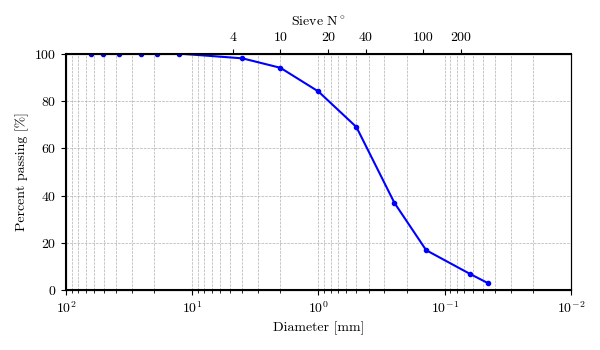

In [9]:
plot_granulometric_curve(df_full, figsize=[6., 3.5])

In [10]:
# Imagen interactiva
style = {'description_width': '100px'}
interact(  # Interactive widgets
    get_Cc_Cu,
    df=fixed(df_full),
    hztl=widgets.FloatSlider(value=50, step=1, min=0, max=100, description="Auxiliar line", style=style),
    D60=widgets.FloatLogSlider(value=1, step=0.1, min=-2, max=2, base=10, description="D60", style=style),
    D30=widgets.FloatLogSlider(value=1, step=0.1, min=-2, max=2, base=10, description="D30", style=style),
    D10=widgets.FloatLogSlider(value=1, step=0.1, min=-2, max=2, base=10, description="D10", style=style),
    widget=fixed(True)
    )

interactive(children=(FloatSlider(value=50.0, description='Auxiliar line', step=1.0, style=SliderStyle(descrip…

<function __main__.get_Cc_Cu(df, hztl, D60=1, D30=1, D10=1, widget=False)>

## Probabilistic fit to granulometric data

### Discrete input data

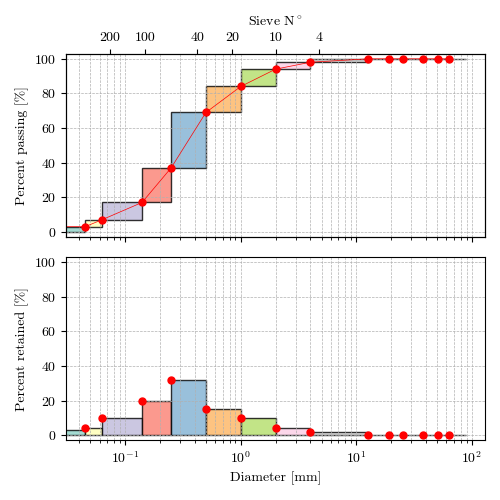

In [11]:
plot_pdf_cdf_granulometric_curve(df_full, figsize=[5, 5])

### Fitting of a lognormal distribution to a grain size distribution curve: 

Si una variable aleatoria $Y=\log X$ se distribuye normalmente con media $\mu$ y desviación estándar $\sigma$, entonces la variable aleatoria $X$ es lognormalmente ditribuida con parámetros de forma (`s`=$\sigma$) y escala (`scale`=$e^\mu$)


La función de densidad de probabilidad de distribución lognormal estandarizada sólo es función del parámetro de forma `s`:

$f(x, s) = \frac{1}{s x \sqrt{2\pi}} \exp\left(-\frac{\log^2(x)}{2s^2}\right)$

con $x > 0$, $s > 0$.

En Python, el parámetro `scale`, y un tercer parametro `loc` se usan para desplazar y/o escalar la función.  De esta manera, una variable aleatoria `x` que se distribuye lognormalmente se define como `lognorm(x, s, loc, scale)` o equivalentemente como `lognorm(z, s) / scale`, donde `z = (x - loc) / scale`, lo que significa que `loc` y `scale` son iguales a 0 y 1 respectivamente en la forma estandarizada.

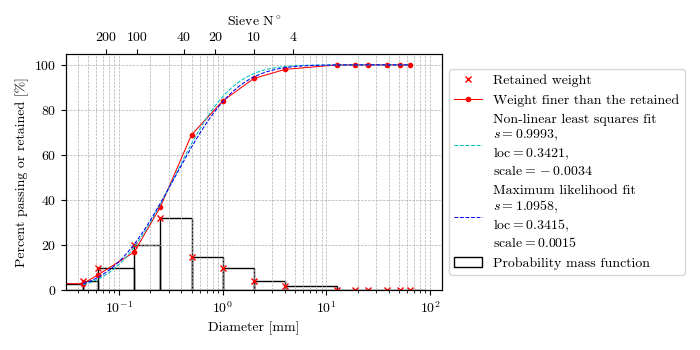

In [12]:
plot_granulometric_curve_fit(df_full, figsize=[7, 3.5])